# Emotion Classification Preprocessing


In [3]:
import os 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_md
nlp = en_core_web_md.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import swifter
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
import glob
import emoji
import contractions
from emot.core import emot #use to convert emoticons to text 
from emot.emo_unicode import EMOTICONS_EMO
import torch
from torch import nn ,cuda

In [2]:
torch.cuda.empty_cache()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## 1. Data Understanding

In this first phase, we will import the dataset and look at the data present and the data shape

In [7]:
folder_path = 'data/'
file_pattern = folder_path + '*.tsv'
tsv_files = glob.glob(file_pattern)


for tsv_file in tsv_files:
    if 'train' in tsv_file:
        df_train = pd.read_csv(tsv_file, sep='\t', header=None, names=['text', 'emotion_ids', 'id'])
    elif 'dev' in tsv_file:
        df_val = pd.read_csv(tsv_file, sep='\t', header=None, names=['text', 'emotion_ids', 'id']).drop('id', axis=1)
    else:
        df_test = pd.read_csv(tsv_file, sep='\t', header=None, names=['text', 'emotion_ids', 'id']).drop('id', axis=1)

In [100]:
df_train.head(10)

,text,emotion_ids
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,26
6,Yes I heard abt the f bombs! That has to be wh...,15
7,We need more boards and to create a bit more s...,"8,20"
8,Damn youtube and outrage drama is super lucrat...,0
9,It might be linked to the trust factor of your...,27


Shape of train, validation and test datasets

In [101]:
data_size = df_train.shape[0] + df_val.shape[0] + df_test.shape[0]
print ("Total number of comments:" , data_size)

Total number of comments: 54263


In [103]:
# Create a dictionary with the information
data_info = {
    'Dataset': ['Train', 'Validation', 'Test'],
    'Rows': [df_train.shape[0], df_val.shape[0], df_test.shape[0]],
    'Percentage': [round(df_train.shape[0] / data_size * 100), round(df_val.shape[0] / data_size * 100), round(df_test.shape[0] / data_size * 100)]
}

# Create a DataFrame from the dictionary
size_df = pd.DataFrame(data_info)
size_df

,Dataset,Rows,Percentage
0,Train,43410,80
1,Validation,5426,10
2,Test,5427,10


### Label Mapping

In [8]:
def map_labels(labels):
    #Read the emotions and store in array
    emotion_array =  np.genfromtxt(folder_path+'emotions.txt', delimiter='\n', dtype=str)
    
    split = labels.split(",")
    result = []
    
    for num in split:
        num = int(num)
        if num <= len(emotion_array):
            result.append(emotion_array[num])
        else:
            result.append(None)  # Handle out-of-range numbers
            
    return result

In [9]:
df_train['emo_labels'] = df_train['emotion_ids'].apply(map_labels)

In [10]:
df_val['emo_labels'] = df_val['emotion_ids'].apply(map_labels)
df_test['emo_labels'] = df_test['emotion_ids'].apply(map_labels)

In [11]:
df_train.head(10)

,text,emotion_ids,emo_labels
0,My favourite food is anything I didn't have to...,27,[neutral]
1,"Now if he does off himself, everyone will thin...",27,[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,2,[anger]
3,To make her feel threatened,14,[fear]
4,Dirty Southern Wankers,3,[annoyance]
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,26,[surprise]
6,Yes I heard abt the f bombs! That has to be wh...,15,[gratitude]
7,We need more boards and to create a bit more s...,"8,20","[desire, optimism]"
8,Damn youtube and outrage drama is super lucrat...,0,[admiration]
9,It might be linked to the trust factor of your...,27,[neutral]


## Data Pre-processing

In [12]:
#convert emoticons to text equivalent
def handle_emoticons(text):
    
    #the library does not handle <3 emoticon, so converting it manually 
    text = re.sub(r"<3", " love ", text)
    
    for emoticon, description in EMOTICONS_EMO.items():
        text = text.replace(emoticon, description)
    
    return text

In [13]:
#convert emoticons to text equivalent
def handle_emojis(text):
        
    #Demojize - Translate emojis to text equivalent
    return emoji.demojize(text)

In [8]:
def clean_text(text):
    chars_to_remove = ["’", "‘", "–", "—", "~", "|", "“", "”", "…", "'", "`", "_","“"]
    rx = '[' + re.escape(''.join(chars_to_remove)) + ']'
    
    #handle emoticons and emojis
    text = handle_emoticons (text)
    text = handle_emojis (text)

    text = text.lower()# lower case
    
    #fix contraction from text
    #Fix contraction before removing punctuation is important 
    text = contractions.fix(text)

    text = re.sub(r"http\S*|\S*\.com\S*|\S*www\S*", " ", text)# eliminate urls
    text = re.sub(r"\s@\S+", " ", text)# eliminate @mentions
    
    text = re.sub(r'[^\w\s]',' ', text) #remove all punctuations
    text = re.sub(r'\n', '', text) #remove line breaks
    text = re.sub(rx, ' ', text)

    text = re.sub(r"\s+", " ", text) # replace all whitespaces with a single space
    text = text.strip() #remove leading and trailing spaces


    return text    

In [15]:
df_train['clean_text'] = df_train['text'].apply(clean_text)

In [16]:
df_val['clean_text'] = df_val['text'].apply(clean_text)
df_test['clean_text'] = df_test['text'].apply(clean_text)

In [17]:
df_train.iloc[[82, 21]]

,text,emotion_ids,emo_labels,clean_text
82,sorry [NAME]! 😘😘😘,25,[sadness],sorry name face blowing a kiss face blowing a ...
21,i got a bump and a bald spot. i feel dumb <3,12,[embarrassment],i got a bump and a bald spot i feel dumb love


In [30]:
# Find and print rows with NaN values in the specified column
empty_rows = df_train[df_train['clean_text'].isna() | df_train['clean_text'].eq('')]
empty_rows

,text,emotion_ids,emo_labels,clean_text


In [29]:
# Drop rows where the specified column is empty ('')
df_train = df_train.loc[df_train['clean_text'] != '']

## Explanatory Data Analysis

### Label count analysis

Count number of labels per each text - Check the distribution

In [31]:
cardinality_df = pd.DataFrame()

cardinality_df['train'] = (df_train['emo_labels'].apply(lambda arr: len(arr))).value_counts()
cardinality_df['val'] = (df_val['emo_labels'].apply(lambda arr: len(arr))).value_counts()
cardinality_df['test'] = (df_test['emo_labels'].apply(lambda arr: len(arr))).value_counts()
cardinality_df['label_count'] = ['1', '2', '3', '4', '5']

In [32]:
cardinality_df = cardinality_df.fillna(0).astype({'train': int, 'val': int, 'test': int})
cardinality_df

,train,val,test,label_count
1,36307,4548,4590,1
2,6541,809,774,2
3,532,62,61,3
4,28,7,2,4
5,1,0,0,5


In [33]:
# Melt the DataFrame to create a long format
card_df = pd.melt(cardinality_df, id_vars='label_count', value_vars=['train', 'val', 'test'], var_name='Category', value_name='Value')

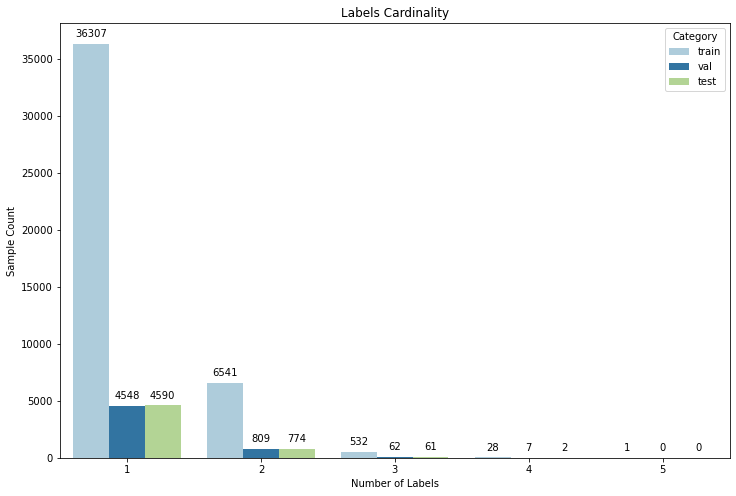

In [34]:
# Plotting grouped bar chart to see labels count for each set 
plt.figure(figsize=(12, 8))
sns.set_palette("Paired")
ax= sns.barplot(x='label_count', y='Value', hue='Category', data=card_df)

# Annotate each bar with its value
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    
# Set labels and title
plt.xlabel('Number of Labels')
plt.ylabel('Sample Count')
plt.title('Labels Cardinality')

# Show the plot
plt.show()

In [35]:
#drop the comments that have 5 labels -- not enough data for model to learn
df_train.shape

(43409, 4)

In [36]:
# Use apply to create a mask
mask = df_train['emo_labels'].apply(lambda x: len(x) < 5)

# Filter the train dataset and remove rows that have 5 labels
df_train = df_train[mask]

In [37]:
df_train.shape

(43408, 4)

Further preprocessing for word analysis per emotions

In [38]:
emotion_array = [line.strip() for line in open(folder_path+'emotions.txt', "r").readlines()]

In [39]:
##Other preprocessing steps
for i in emotion_array:
    df_train[i] = df_train['emo_labels'].apply(lambda x: 1 if i in x else 0)
    df_val[i] = df_val['emo_labels'].apply(lambda x: 1 if i in x else 0)
    df_test[i] = df_test['emo_labels'].apply(lambda x: 1 if i in x else 0)

In [40]:
drop_cols = ['text','emotion_ids', 'emo_labels']

df_train.drop(drop_cols, axis=1, inplace=True)
df_val.drop(drop_cols, axis=1,inplace=True)
df_test.drop(drop_cols, axis=1, inplace=True)

In [41]:
df_train.head(10)

,clean_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,my favourite food is anything i did not have t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,now if he does off himself everyone will think...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,why the fuck is bayless isoing,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,to make her feel threatened,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,dirty southern wankers,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,omg peyton is not good enough to help us in th...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,yes i heard about the f bombs that has to be w...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,we need more boards and to create a bit more s...,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
8,damn youtube and outrage drama is super lucrat...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,it might be linked to the trust factor of your...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Emotion Distribution Analysis


In [42]:
# Computing number of samples per emotion
train_emo_count = df_train.loc[:,emotion_array].sum(axis=0).sort_index(ascending=True)
val_emo_count = df_val.loc[:,emotion_array].sum(axis=0).sort_index(ascending=True)
test_emo_count = df_test.loc[:,emotion_array].sum(axis=0).sort_index(ascending=True)

In [43]:
counts_df = pd.DataFrame({'emotion': train_emo_count.index, 'train': train_emo_count.values, 'val': val_emo_count, 'test': test_emo_count})
counts_df = counts_df.sort_values(by='train', ascending=False)
counts_df

,emotion,train,val,test
neutral,neutral,14218,1766,1787
admiration,admiration,4130,488,504
approval,approval,2939,397,351
gratitude,gratitude,2662,358,352
annoyance,annoyance,2470,303,320
amusement,amusement,2328,303,264
curiosity,curiosity,2191,248,284
love,love,2086,252,238
disapproval,disapproval,2022,292,267
optimism,optimism,1581,209,186


In [44]:
# Melt the DataFrame to create a long format
emo_count_df = pd.melt(counts_df, id_vars='emotion', value_vars=['train', 'val', 'test'], var_name='Category', value_name='Value')

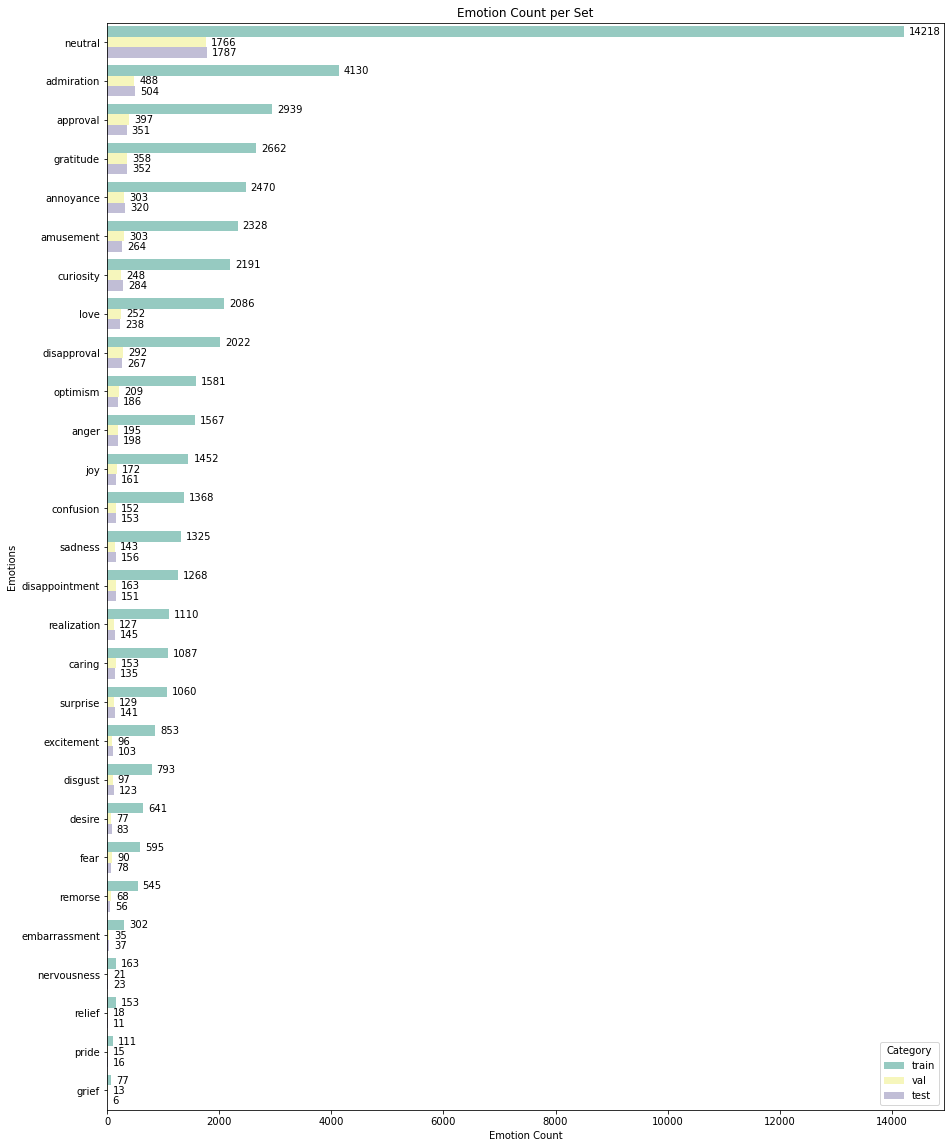

In [45]:
# Plotting grouped bar chart to see labels count for each set 
plt.figure(figsize=(15, 20))
custom_palette = sns.color_palette("Set3")

ax= sns.barplot(x='Value', y='emotion', hue='Category', data=emo_count_df, palette=custom_palette)

# Annotate each bar with its value
for p in ax.patches:
    width = p.get_width()
    plt.annotate(f'{int(width)}', xy=(width, p.get_y() + p.get_height() / 2), xytext=(5, 0),
                 textcoords='offset points', ha='left', va='center')

    
# Set labels and title
plt.xlabel('Emotion Count')
plt.ylabel('Emotions')
plt.title('Emotion Count per Set')

# Show the plot
plt.show()

### Word by Emotion Analysis


In [111]:
#extract the emotion labels
target_cols = [col for col in df_train.columns if col not in ['clean_text']]

In [112]:
#join all to form complete datasset
result_concat = pd.concat([df_train, df_val, df_test], axis=0, ignore_index=True)

In [114]:
result_concat.shape

(54261, 29)

In [164]:
# Function to display 10 most frequent words in a list of comments
def plot_top_words_barchart(comments, axes):

    comments = comments.str.split() # split each comment into a list of words
    comments = comments.values.tolist() # from pandas series to lists of words
    corpus = [word for sample in comments for word in sample if word not in list(STOP_WORDS)+["?","!","name"]] # giant corpus of words excluding special characters
    counter = Counter(corpus) # create a counter
    most = counter.most_common(10) # retrieve the 10 most frequent words

    # Plot the 10 top words and their frequencies
    most = [(word, count) for (word, count) in most]
    x, y = [], []
    for word, count in most[:6]:
        x.append(word)
        y.append(count)   
    

    sns.barplot(x=y, y=x , ax=axes, palette="Blues")
    # Annotate each bar with its count
    for i, count in enumerate(y):
        axes.text(count, i, f'{count}', ha='right', va='center', color='black', fontweight='bold')
    
    return table_data

In [165]:
targets = ['admiration', 'anger', 'realization', 'neutral']

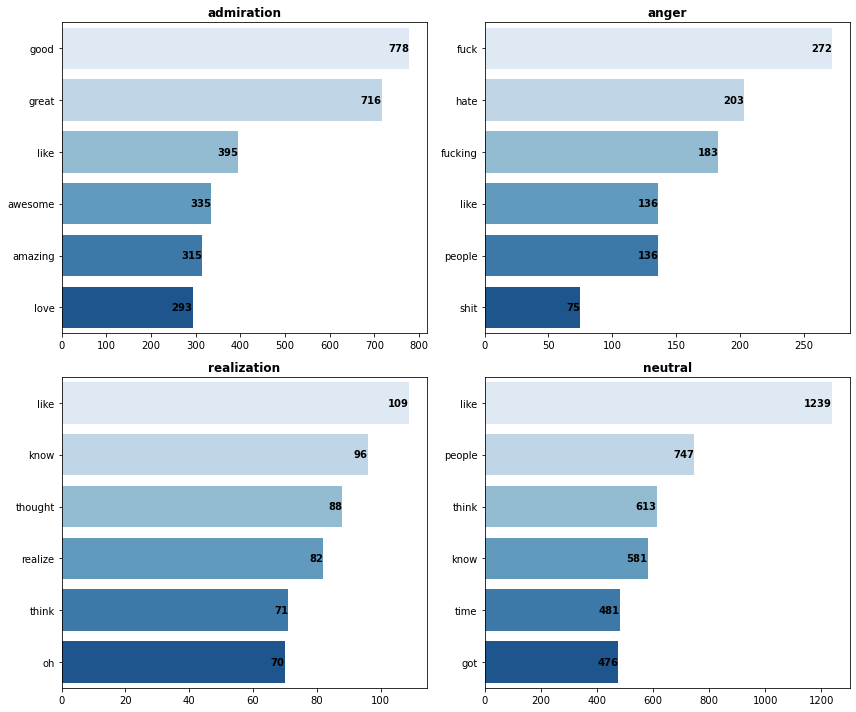

In [169]:
# Displaying 10 most frequent words for each emotion
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# fig.suptitle('Top 6 words per emotion', fontweight="bold", fontsize=20)
all_emo= []
for i, axi in enumerate(axes.flat):
    plot_top_words_barchart(result_concat.loc[result_concat[targets[i]]==1,"clean_text"], axi)
    axi.set_title(targets[i], fontweight="bold")
    
    
plt.tight_layout()
# fig.subplots_adjust(top=0.8)
plt.show()
     

In [121]:
def print_top_word(comments):

    comments = comments.str.split() # split each comment into a list of words
    comments = comments.values.tolist() # from pandas series to lists of words
    corpus = [word for sample in comments for word in sample if word not in list(STOP_WORDS)+["?","!","name"]] # giant corpus of words excluding special characters
    counter = Counter(corpus) # create a counter
    most = counter.most_common(10) # retrieve the 10 most frequent words

    # Plot the 10 top words and their frequencies
    most = [(word, count) for (word, count) in most]
    x, y = [], []
    for word, count in most[:6]:
        x.append(word)
        y.append(count)   
    
    table_data = list(zip(x, y))
    # Define table headers
    headers = ['Word', 'Count']
    
    print (table_data)
    # Print the table using tabulate
#     print(tabulate(table_data, headers=headers, tablefmt='fancy_grid'))


In [122]:
#print top 6 words by emotions
for i, axi in enumerate(target_cols):
    print (target_cols[i])
    print_top_word(result_concat.loc[result_concat[target_cols[i]]==1,"clean_text"])


admiration
[('good', 778), ('great', 716), ('like', 395), ('awesome', 335), ('amazing', 315), ('love', 293)]
amusement
[('lol', 1242), ('haha', 335), ('funny', 260), ('like', 228), ('fun', 178), ('face', 174)]
anger
[('fuck', 272), ('hate', 203), ('fucking', 183), ('like', 136), ('people', 136), ('shit', 75)]
annoyance
[('like', 268), ('people', 226), ('fucking', 129), ('stupid', 120), ('damn', 111), ('shit', 109)]
approval
[('like', 311), ('agree', 228), ('good', 221), ('right', 215), ('yeah', 200), ('yes', 192)]
caring
[('good', 126), ('better', 88), ('like', 79), ('help', 78), ('feel', 74), ('hope', 72)]
confusion
[('know', 225), ('sure', 155), ('like', 129), ('think', 101), ('confused', 99), ('people', 84)]
curiosity
[('like', 196), ('know', 160), ('curious', 142), ('people', 110), ('think', 105), ('right', 82)]
desire
[('wish', 284), ('want', 150), ('like', 85), ('need', 59), ('hope', 57), ('love', 48)]
disappointment
[('bad', 144), ('like', 127), ('sad', 73), ('got', 68), ('peopl

### Exporting the clean data

In [47]:
dir_path = 'data/clean'

# Create the directory if it doesn't exist
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

# Set index=False to exclude the DataFrame's index column
df_train.to_csv(dir_path + '/' + 'train.csv', index=False)  
df_val.to_csv(dir_path + '/' + 'val.csv', index=False)  
df_test.to_csv(dir_path + '/' + 'test.csv', index=False)  
